In [2]:
import os
NUM_THREADS = 6
os.environ['OMP_NUM_THREADS'] = str(NUM_THREADS)
os.environ['MKL_NUM_THREADS'] = str(NUM_THREADS)
os.environ['NUMEXPR_NUM_THREADS'] = str(NUM_THREADS)
os.environ["OPENBLAS_NUM_THREADS"] = str(NUM_THREADS)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(NUM_THREADS)

import pyscf
from pyscf import dft

import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

from datasets import QH9Stable, QH9Dynamic
from test_dft_acceleration import matrix_transform
# dataset = QH9Stable(root='datasets')  # 2.2.1
dataset = QH9Dynamic(root=os.path.join(os.sep.join(os.getcwd().split(os.sep)[:-1]), 'datasets'), version='300k')
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
from torch_cluster import radius_graph

import numpy as np
import torch

BOHR2ANG = 1.8897259886


def get_orbital_mask(atom_idx):
    idx_1s_2s = torch.tensor([0, 1])
    idx_2p = torch.tensor([3, 4, 5])
    orbital_mask_line1 = torch.cat([idx_1s_2s, idx_2p])
    orbital_mask_line2 = torch.arange(14)
    orbital_mask = orbital_mask_line1 if atom_idx <= 2 else orbital_mask_line2
    return orbital_mask


def build_final_matrix(data, diagonal_matrix, non_diagonal_matrix):
    final_matrix = []
    matrix_block_col = []
    non_diagonal_idx = 0
    for src_idx in range(data.atoms.shape[0]):
        matrix_col = []
        for dst_idx in range(data.atoms.shape[0]):
            if src_idx == dst_idx:
                matrix_col.append(diagonal_matrix[src_idx].index_select(
                    -2, get_orbital_mask(data.atoms[dst_idx].item())).index_select(
                    -1, get_orbital_mask(data.atoms[src_idx].item())
                ))
            else:
                matrix_col.append(
                    non_diagonal_matrix[non_diagonal_idx].index_select(
                        -2, get_orbital_mask(data.atoms[dst_idx].item())).index_select(
                        -1, get_orbital_mask(data.atoms[src_idx].item())))
                non_diagonal_idx = non_diagonal_idx + 1

        matrix_block_col.append(torch.cat(matrix_col, dim=-2))
    final_matrix.append(torch.cat(matrix_block_col, dim=-1))
    final_matrix = torch.stack(final_matrix, dim=0)
    return final_matrix


/data2/haiyang/anaconda3/envs/QHBench/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/data5/haiyang/equi/AIRS/OpenDFT/QHBench/QH9/test_dft_acceleration.py:267: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='config', config_name='config')


### Check the MAE error between the dataset hamiltonian and the results from PySCF 

In [3]:
check_hamil = False
hamils = []
shapes = []
start_id = 0
for i in range(start_id, start_id + 10):
    data = dataset[i]
    data.atoms = data.atoms.squeeze()
    H_data = build_final_matrix(data, data.diagonal_hamiltonian, data.non_diagonal_hamiltonian)
    atoms = dataset[i].atoms.cpu().squeeze().numpy()

    # H1 = H
    hamiltonian_pyscf = matrix_transform(H_data, atoms, convention='back2pyscf')
    ptable = {1:"H", 2:"He", 3:"Li", 4:"Be", 5:"B", 6:"C", 7:"N", 8:"O", 9:"F"}

    # produce pyscf string
    data.pos = data.pos

    # pyscf
    t = [[data.atoms[atom_idx].cpu().item(), data.pos[atom_idx].cpu().numpy()]
         for atom_idx in range(data.num_nodes)]

    data_m = pyscf.gto.Mole()
    data_m.build(verbose=0, atom=t, basis='def2svp', unit='ang')

    mf_hf_data = dft.RKS(data_m)
    mf_hf_data.xc = 'b3lyp'
    mf_hf_data.basis = 'def2svp'
    mf_hf_data.kernel()
    H_scf_H = mf_hf_data.get_fock()
    print(f"the error is {np.abs(hamiltonian_pyscf - H_scf_H).mean()}")

    m = pyscf.gto.Mole()
    m.build(verbose=3, atom=t, basis='def2svp', unit='ang')
    m.build()


the error is 1.018103904274355e-07
the error is 1.0398874702355039e-07
the error is 1.040262286925233e-07
the error is 1.0642375272646404e-07
the error is 1.1464225544930597e-07
the error is 1.3952326930706611e-07
the error is 1.738399162366277e-07
the error is 1.7563097677604167e-07
the error is 1.42459335964232e-07
the error is 2.0054334540942894e-07


### Check the MAE of the Hamiltonian Matrix

The x-axis denotes molecule index, and y-axis denotes the MAE on Hamiltonian matrix of MD simluations structures and the inital structures.  
We can find that here is a distinctive MAE difference on Hamiltonian matrix between the MD structures and the inital strcutres.

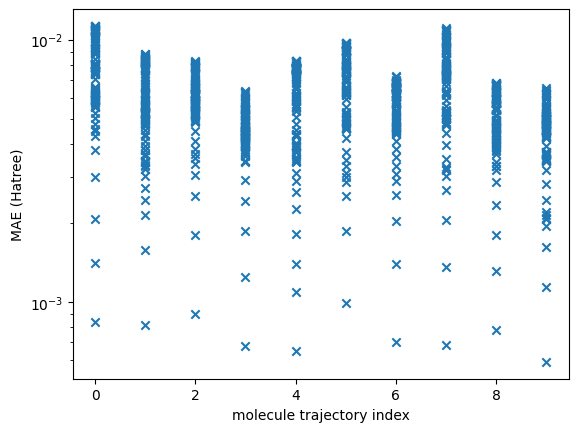

In [6]:
import matplotlib.pyplot as plt
# select the molecule index
start_id = 0

mae_results = []
x_axis = []
ptable = {1: "H", 2: "He", 3: "Li", 4: "Be", 5: "B", 6: "C", 7: "N", 8: "O", 9: "F"}
for molecule_idx in range(start_id, start_id + 10):
    data_i = dataset[molecule_idx * 100]
    H_i = build_final_matrix(
        data_i, data_i.diagonal_hamiltonian, data_i.non_diagonal_hamiltonian)
    hamiltonian_pyscf = matrix_transform(H_i.squeeze(), data_i.atoms.squeeze(), convention='back2pyscf')
    for j in range(0, 100):
        data_j = dataset[molecule_idx * 100 + j]
        H_j = build_final_matrix(
            data_j, data_j.diagonal_hamiltonian, data_j.non_diagonal_hamiltonian)
        hamiltonian_pyscf = matrix_transform(H_j, data_j.atoms, convention='back2pyscf')
        x_axis.append(int(molecule_idx))
        mae_results.append(torch.mean((H_i - H_j).abs()))
plt.yscale('log')
plt.scatter(x=x_axis, y=mae_results, marker='x')
plt.xlabel('molecule trajectory index')
plt.ylabel('MAE (Hatree)')
plt.show()

### Check the MD Simluations

We can find that the geometric stuctures changes with the MD simulation steps.

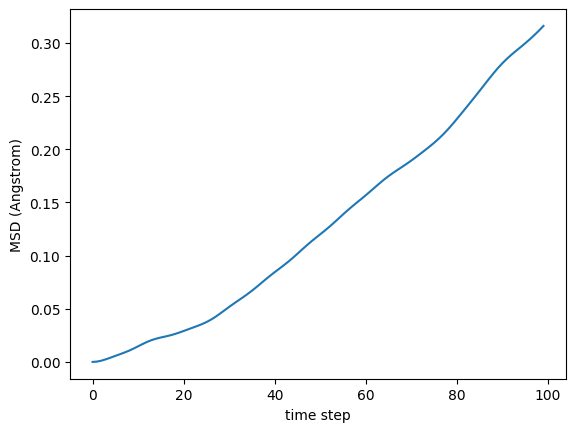

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import MDAnalysis.analysis.msd as msd

# select the molecule index
molecule_idx = 0
coord_list = []
for i in range(molecule_idx * 100, (molecule_idx + 1)* 100):
    coord_list.append(dataset[i].pos.numpy())
molecule = dataset[molecule_idx * 100].atoms.squeeze().numpy()


sol = mda.Universe.empty(molecule.shape[0], n_residues=1,trajectory=True)
sol.add_TopologyAttr('type', molecule)

sol.load_new(np.stack(coord_list))
MSD = msd.EinsteinMSD(sol, select='all', msd_type='xyz', fft=True)
MSD.run()
msd = MSD.results.timeseries
nframes = MSD.n_frames
fig = plt.figure()
ax = plt.axes()
lagtimes = np.arange(nframes)
ax.plot(lagtimes, msd,  ls="-", label=r'MSD')
plt.xlabel('time step')
plt.ylabel('MSD (Angstrom)')
plt.show()